In [0]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from scipy import stats
from scipy.stats import normaltest
from math import sqrt
import warnings

warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [3]:
df = pd.read_csv('Data/jena_climate_2016.csv')
df.head() 

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
368291,01.01.2016 00:00:00,999.08,-0.01,273.22,-0.44,96.9,6.10,5.91,0.19,3.69,5.92,1271.32,1.16,2.04,192.4
368292,01.01.2016 00:10:00,999.03,0.01,273.25,-0.41,97.0,6.11,5.93,0.18,3.70,5.94,1271.16,1.01,2.12,211.6
368293,01.01.2016 00:20:00,999.07,0.06,273.29,-0.36,97.0,6.13,5.95,0.18,3.71,5.96,1270.97,0.80,1.52,203.8
368294,01.01.2016 00:30:00,999.09,0.07,273.30,-0.36,96.9,6.14,5.95,0.19,3.71,5.96,1270.93,0.77,1.64,184.2
368295,01.01.2016 00:40:00,999.09,-0.05,273.18,-0.50,96.8,6.09,5.89,0.19,3.68,5.90,1271.54,0.84,1.92,200.1


In [0]:
df['Date Time'] = pd.to_datetime(df['Date Time'], format = '%d.%m.%Y %H:%M:%S')
df = df.set_index('Date Time')

In [8]:
df = df[:1000]
df.head()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2016-01-01 00:00:00,999.08,-0.01,273.22,-0.44,96.9,6.10,5.91,0.19,3.69,5.92,1271.32,1.16,2.04,192.4
2016-01-01 00:10:00,999.03,0.01,273.25,-0.41,97.0,6.11,5.93,0.18,3.70,5.94,1271.16,1.01,2.12,211.6
2016-01-01 00:20:00,999.07,0.06,273.29,-0.36,97.0,6.13,5.95,0.18,3.71,5.96,1270.97,0.80,1.52,203.8
2016-01-01 00:30:00,999.09,0.07,273.30,-0.36,96.9,6.14,5.95,0.19,3.71,5.96,1270.93,0.77,1.64,184.2
2016-01-01 00:40:00,999.09,-0.05,273.18,-0.50,96.8,6.09,5.89,0.19,3.68,5.90,1271.54,0.84,1.92,200.1


Extract a univariate time series, specifically temperature

In [9]:
temperature = df['T (degC)']
temperature.head()

Date Time
2016-01-01 00:00:00   -0.01
2016-01-01 00:10:00    0.01
2016-01-01 00:20:00    0.06
2016-01-01 00:30:00    0.07
2016-01-01 00:40:00   -0.05
Name: T (degC), dtype: float64

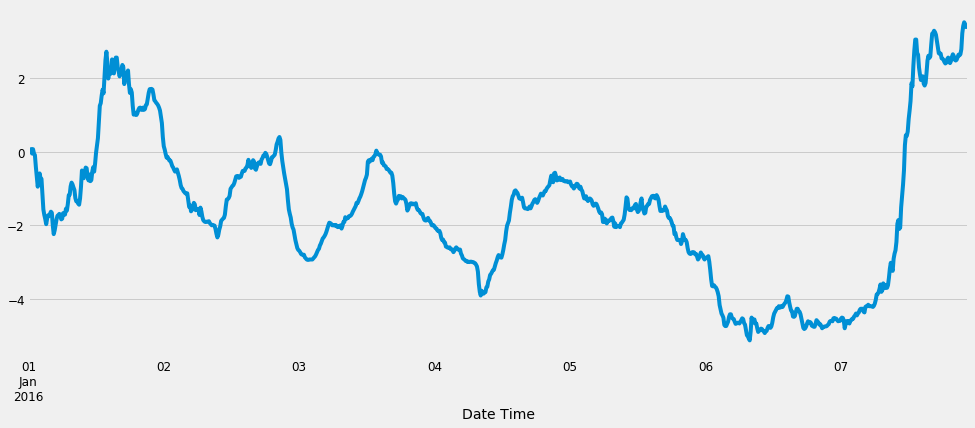

In [10]:
temperature.plot(figsize=(15,6))
plt.show()

We check for the stationarity of the data

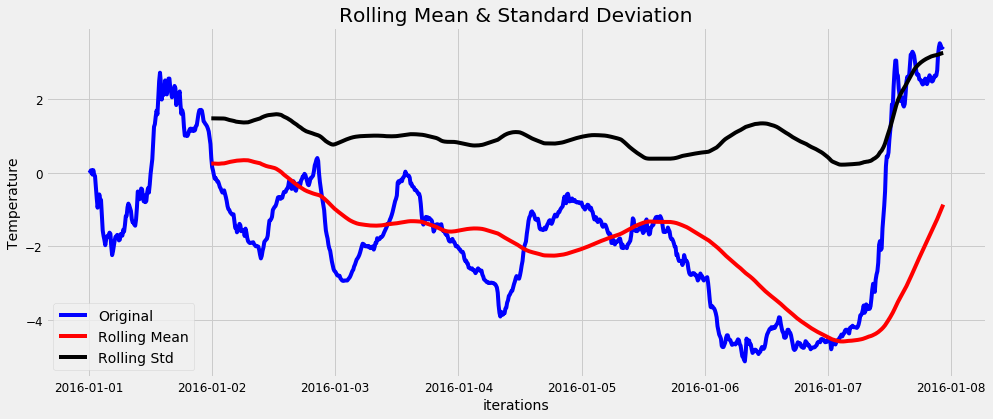

In [11]:
rolmean = pd.Series(temperature).rolling(window=144).mean()
rolstd = pd.Series(temperature).rolling(window=144).std()

itr = range(len(rolmean))

#Plot rolling statistics:
plt.figure(figsize=(15,6))
plt.xlabel("iterations")
plt.ylabel("Temperature")
plt.title("Rolling Mean and rolling standard deviation")
orig = plt.plot(temperature, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

We can further perform Augmented Dickey-Fuller test, to test stationarity of the temperature time series.
Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [12]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(temperature)
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.865940
p-value                          0.348250
#Lags Used                      11.000000
Number of Observations Used    988.000000
Critical Value (1%)             -3.436986
Critical Value (5%)             -2.864470
Critical Value (10%)            -2.568330
dtype: float64


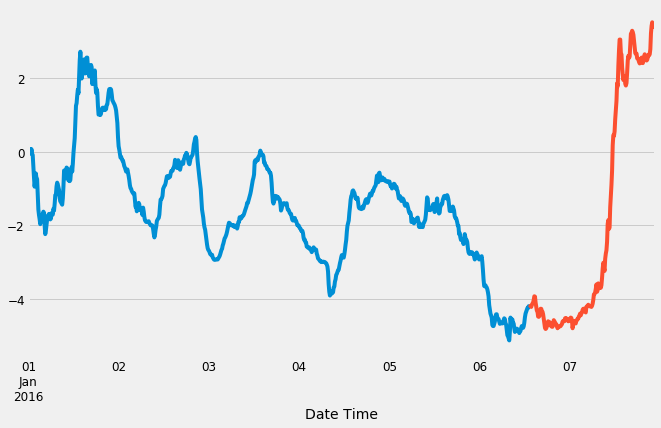

In [13]:
#divide into train and validation set
plt.figure(figsize=(10,6))

train = temperature[:int(0.8*(len(temperature)))]
test = temperature[int(0.8*(len(temperature))):]

#plotting the data
train.plot()
test.plot()

The temperature time series is not stationary. Let us find out the order of differencing

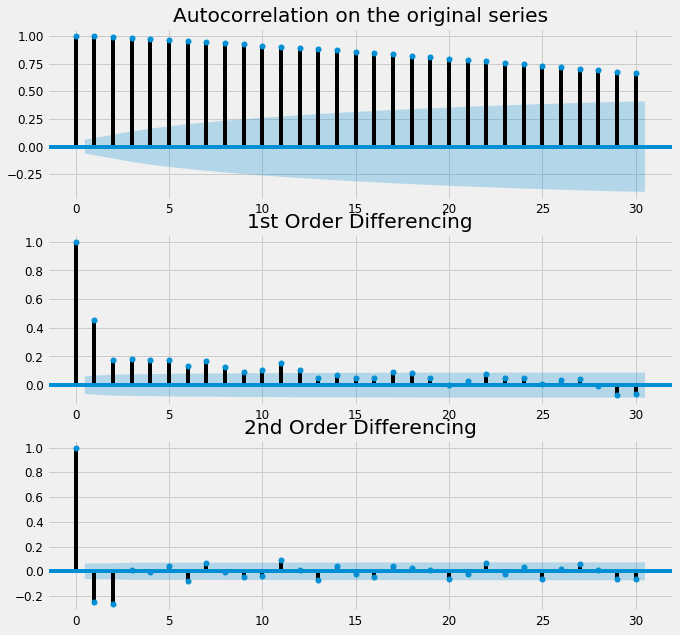

In [0]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(temperature, ax =ax1, title='Autocorrelation on the original series')
ax2 = fig.add_subplot(312)
fig = plot_acf(temperature.diff().dropna(), ax=ax2, title='1st Order Differencing')
ax3 = fig.add_subplot(313)
fig = plot_acf(temperature.diff().diff().dropna(), ax=ax3, title='2nd Order Differencing')

In [0]:
def forecast(data,train, test):
  #data = pd.Series(data)
  #size = int(0.8*len(data))
  #train = data[:size]
  #test = data[size:]
  train = pd.Series(train)
  test = pd.Series(test)
  history = train.to_list()
  predictions = []
  for t in range(len(test)):
    model = ARIMA(history, order = (1,2,1))
    model_fit = model.fit()
    hat = model_fit.forecast()[0]
    predictions.append(np.asscalar(hat))
    history.append(pd.Series(hat))
  MSE = mean_squared_error(test, predictions)
  RMSE = sqrt(MSE)
  return RMSE, predictions

In [15]:
rmse, predictions = forecast(temperature,train, test)

0.8467622780848562


In [16]:
rmse

2.057622752212922

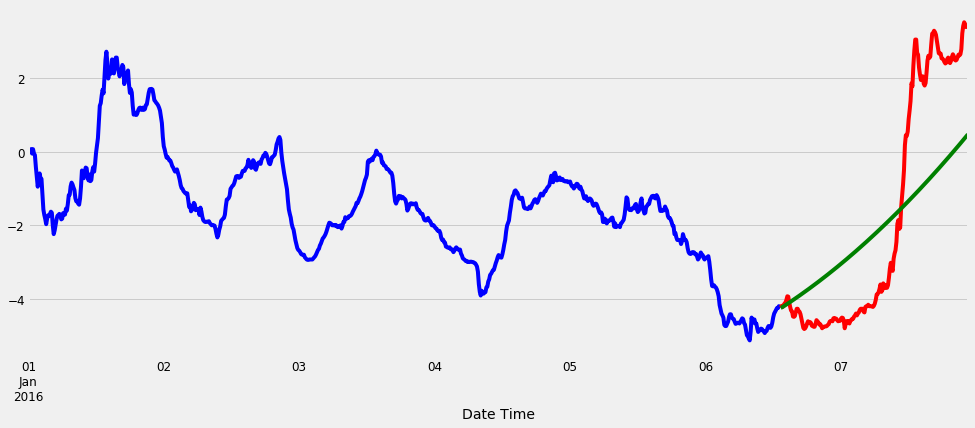

In [20]:
pred = pd.Series(predictions, index=test.index)
train.plot(figsize=(15,6),color='blue')
test.plot(color='red')
pred.plot(color='green')

In [0]:
model = ARIMA(train, order = (1,2,1))
model_fit = model.fit(disp=0)


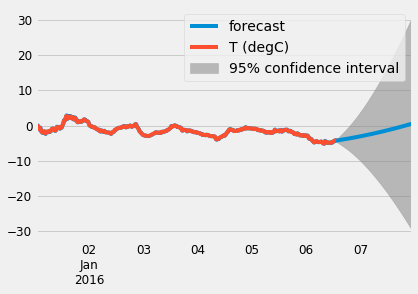

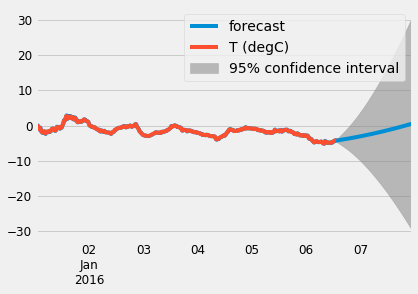

In [22]:
model_fit.plot_predict(2,1000)